In [3]:
import xarray as xr
import matplotlib.pyplot as plt
from utility import analysis_parameters as ap
from utility import util
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

var="cltotal"
model="ICON"
topdown=True # False for NICAM and SAM; all else True

chunk_dict = {"time":80,"lat":71, "lon":71, "Xdim":1000, "ncol":1000}
diff=False
lev=0

In [2]:
ds = xr.open_dataset(ap.get_file(model, "TWP_3D", var), chunks=chunk_dict)[var]
if model=="GEOS" or model=="SCREAM" or model=="ICON":
    z = xr.open_dataset(ap.get_file(model, "TWP_3D", "zg"), chunks=chunk_dict).zg
    print(z[:,0].values)
elif model=="SAM":
    z = ds.z
    print(z[0].values)
elif model=="NICAM":
    z = ds.lev
    print(z[0].values)
if model=="GEOS":
    ds = ds[::3]
    z = z[::3]
    print(z[0].values)
    print(ds.time.values[0], z[0].time.values)
print(ds.shape, z.shape)
ds

[########################################] | 100% Completed | 403.84 ms
[[45120.61  45120.63  45120.637 ... 45120.203 45120.18  45120.15 ]
 [45121.227 45121.125 45121.293 ... 45120.38  45120.52  45120.44 ]
 [45120.42  45120.35  45120.477 ... 45120.613 45120.7   45120.75 ]
 ...
 [45120.957 45120.906 45120.938 ... 45120.984 45121.113 45121.17 ]
 [45120.598 45120.48  45120.723 ... 45122.188 45122.49  45122.547]
 [45122.24  45122.184 45122.23  ... 45120.664 45120.617 45120.6  ]]
(210, 77, 195442) (210, 76, 195442)


<xarray.DataArray 'cltotal' (time: 210, height: 77, cell: 195442)>
dask.array<open_dataset-247a05a734dcf423abf5296eee2bb08acltotal, shape=(210, 77, 195442), dtype=float32, chunksize=(80, 77, 195442), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28T21:00:00
    clon     (cell) float64 dask.array<chunksize=(195442,), meta=np.ndarray>
    clat     (cell) float64 dask.array<chunksize=(195442,), meta=np.ndarray>
  * height   (height) float64 14.0 15.0 16.0 17.0 18.0 ... 87.0 88.0 89.0 90.0
Dimensions without coordinates: cell
Attributes:
    standard_name:  mass_fraction_of_cloud_ice_in_air
    long_name:      Specific cloud ice content (diagnostic) 
    units:          kg kg-1
    param:          213.1.0
    CDI_grid_type:  unstructured
    origin:         QI_DIA

In [2]:
thres=1e-5

#initialize arrays to zeros
cldtop = np.zeros(ds[:,0].shape)
cldtopind = np.zeros(ds[:,0].shape)

if model=="SAM":
    for l in range(1,len(ds.z)):
        print(-l, z[-l])
        cldtop = np.where((cldtop==0)&(ds.isel(z=-l)>thres), z[-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(z=-l)>thres), -l, cldtopind)
elif model=="ICON":
    for l in range(18,len(ds.height)-1):
        print(l)
        cldtop = np.where((cldtop==0)&(ds.isel(height=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(height=l)>thres), l, cldtopind)
elif model=="SCREAM":
    for l in range(0,len(ds.lev)-1):
        print(l, z[0,l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="GEOS":
    for l in range(75,len(ds.lev)-1):
        print(l, z[0,l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="NICAM": #NICAM
    for l in range(1,len(ds.lev)-1):
        print(-l, z[0,-l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=-l)>thres), z[:,-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=-l)>thres), -l, cldtopind)
else:
    raise Exception("model not defined")

In [ ]:
cldtop, thres

In [8]:
if model=="GEOS":
    da = xr.DataArray(cldtop, dims=["time","Xdim"], coords={"time":ds.time,"Xdim":ds.Xdim}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","Xdim"], coords={"time":ds.time,"Xdim":ds.Xdim}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="SCREAM":
    da = xr.DataArray(cldtop, dims=["time","ncol"], coords={"time":ds.time,"ncol":ds.ncol}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","ncol"], coords={"time":ds.time,"ncol":ds.ncol}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="ICON":
    da = xr.DataArray(cldtop, dims=["time","cell"], coords={"time":ds.time,"cell":ds.cell}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","cell"], coords={"time":ds.time,"cell":ds.cell}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
else:
    da = xr.DataArray(cldtop, dims=["time","lat","lon"], coords={"time":ds.time,"lat":ds.lat,"lon":ds.lon}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","lat","lon"], coords={"time":ds.time,"lat":ds.lat,"lon":ds.lon}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})


In [9]:
model

'ICON'

In [10]:
file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_20200130-20200228.nc".format(model)
# ds = xr.Dataset({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind},
#                 attrs={"name":"cloud top height", "deets":"calculated in cloudtop.ipynb"})
ds = xr.open_dataset(file)
ds = ds.assign({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind})
ds

<xarray.Dataset>
Dimensions:             (time: 210, cell: 195442)
Coordinates:
  * time                (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02...
  * cell                (cell) int64 0 1 2 3 4 ... 195438 195439 195440 195441
Data variables:
    cldtop_height1e-07  (time, cell) float64 ...
    cldtop_ind1e-07     (time, cell) float64 ...
    cldtop_height1e-06  (time, cell) float64 ...
    cldtop_ind1e-06     (time, cell) float64 ...
    cldtop_height1e-05  (time, cell) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cldtop_ind1e-05     (time, cell) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    name:     cloud top height
    deets:    calculated in cloudtop.ipynb

In [11]:
# ! rm /work/bb1153/b380883/TWP/TWP_ICON_cldtop_height_20200130-20200228.nc
ds.to_netcdf(file)



# plotting

In [4]:
model="ICON"

In [5]:
file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_20200130-20200228.nc".format(model)
ds = xr.open_dataset(file, chunks=chunk_dict)
ds

<xarray.Dataset>
Dimensions:             (time: 210, cell: 195442)
Coordinates:
  * time                (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02...
  * cell                (cell) int64 0 1 2 3 4 ... 195438 195439 195440 195441
Data variables:
    cldtop_height1e-07  (time, cell) float64 dask.array<chunksize=(80, 195442), meta=np.ndarray>
    cldtop_ind1e-07     (time, cell) float64 dask.array<chunksize=(80, 195442), meta=np.ndarray>
    cldtop_height1e-06  (time, cell) float64 dask.array<chunksize=(80, 195442), meta=np.ndarray>
    cldtop_ind1e-06     (time, cell) float64 dask.array<chunksize=(80, 195442), meta=np.ndarray>
    cldtop_height1e-05  (time, cell) float64 dask.array<chunksize=(80, 195442), meta=np.ndarray>
    cldtop_ind1e-05     (time, cell) float64 dask.array<chunksize=(80, 195442), meta=np.ndarray>
Attributes:
    name:     cloud top height
    deets:    calculated in cloudtop.ipynb

[########################################] | 100% Completed | 605.02 ms


(array([3.10436862e-04, 1.44904081e-04, 4.66962099e-05, 3.58390942e-05,
        2.50087361e-05, 2.80529181e-05, 3.20873685e-05, 3.66317296e-05,
        1.21444326e-05, 1.73041638e-05, 3.77678731e-05, 3.24181236e-05,
        4.67867329e-05, 6.63718367e-05, 1.22736569e-04, 5.69049413e-05,
        2.83266437e-05, 1.14779437e-05, 8.02033784e-07, 4.26523079e-08]),
 array([    0.        ,   915.12998047,  1830.25996094,  2745.38994141,
         3660.51992187,  4575.64990234,  5490.77988281,  6405.90986328,
         7321.03984375,  8236.16982422,  9151.29980469, 10066.42978516,
        10981.55976562, 11896.68974609, 12811.81972656, 13726.94970703,
        14642.0796875 , 15557.20966797, 16472.33964844, 17387.46962891,
        18302.59960938]),
 <BarContainer object of 20 artists>)

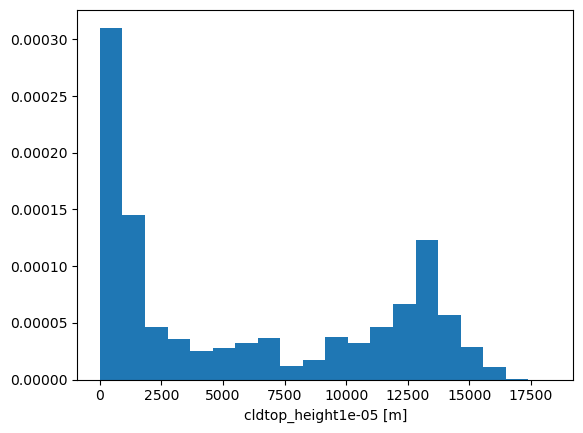

In [6]:
ds["cldtop_height1e-05"].plot.hist(bins=20, density=1)

In [8]:
cldtop_low = ds["cldtop_height1e-06"][:-1]
cldtop_med = ds["cldtop_height1e-05"][:-1]
# cldtop_hgh = ds["cldtop_height1e-04"][:-1]
cldtop_xlw = ds["cldtop_height1e-07"][:-1]

In [10]:
cldtop_low.time[0:2], cldtop_med.shape

(<xarray.DataArray 'time' (time: 2)>
 array(['2020-01-30T03:00:00.000000000', '2020-01-30T06:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * time     (time) datetime64[ns] 2020-01-30T03:00:00 2020-01-30T06:00:00
 Attributes:
     standard_name:  time
     axis:           T,
 (209, 195442))

In [67]:
olr = xr.open_dataset(ap.get_file(model,"TWP","rlt"), chunks=chunk_dict).rlt.sel(time=cldtop_low.time)
olr

<xarray.DataArray 'rlt' (time: 209, cell: 195442)>
dask.array<getitem, shape=(209, 195442), dtype=float32, chunksize=(7, 195442), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28T18:00:00
    clon     (cell) float64 dask.array<chunksize=(195442,), meta=np.ndarray>
    clat     (cell) float64 dask.array<chunksize=(195442,), meta=np.ndarray>
Dimensions without coordinates: cell
Attributes:
    standard_name:  toa_net_downward_longwave_flux_accumulated
    long_name:      Net long wave radiation flux  - accumulated _ model top
    units:          W/m2
    param:          5.5.0
    CDI_grid_type:  unstructured
    level_type:     toa
    origin:         ACCTHB_T

In [68]:
olr.time[0].values, cldtop_low.time[0].values

(numpy.datetime64('2020-01-30T03:00:00.000000000'),
 numpy.datetime64('2020-01-30T03:00:00.000000000'))

In [69]:
olr.time[-1].values, cldtop_low.time[-1].values

(numpy.datetime64('2020-02-28T18:00:00.000000000'),
 numpy.datetime64('2020-02-28T18:00:00.000000000'))

[########################################] | 100% Completed | 1.72 sms
[########################################] | 100% Completed | 505.49 ms
40847378
[########################################] | 100% Completed | 1.36 sms
[########################################] | 100% Completed | 214.11 ms
40847378
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 504.54 ms
40847378


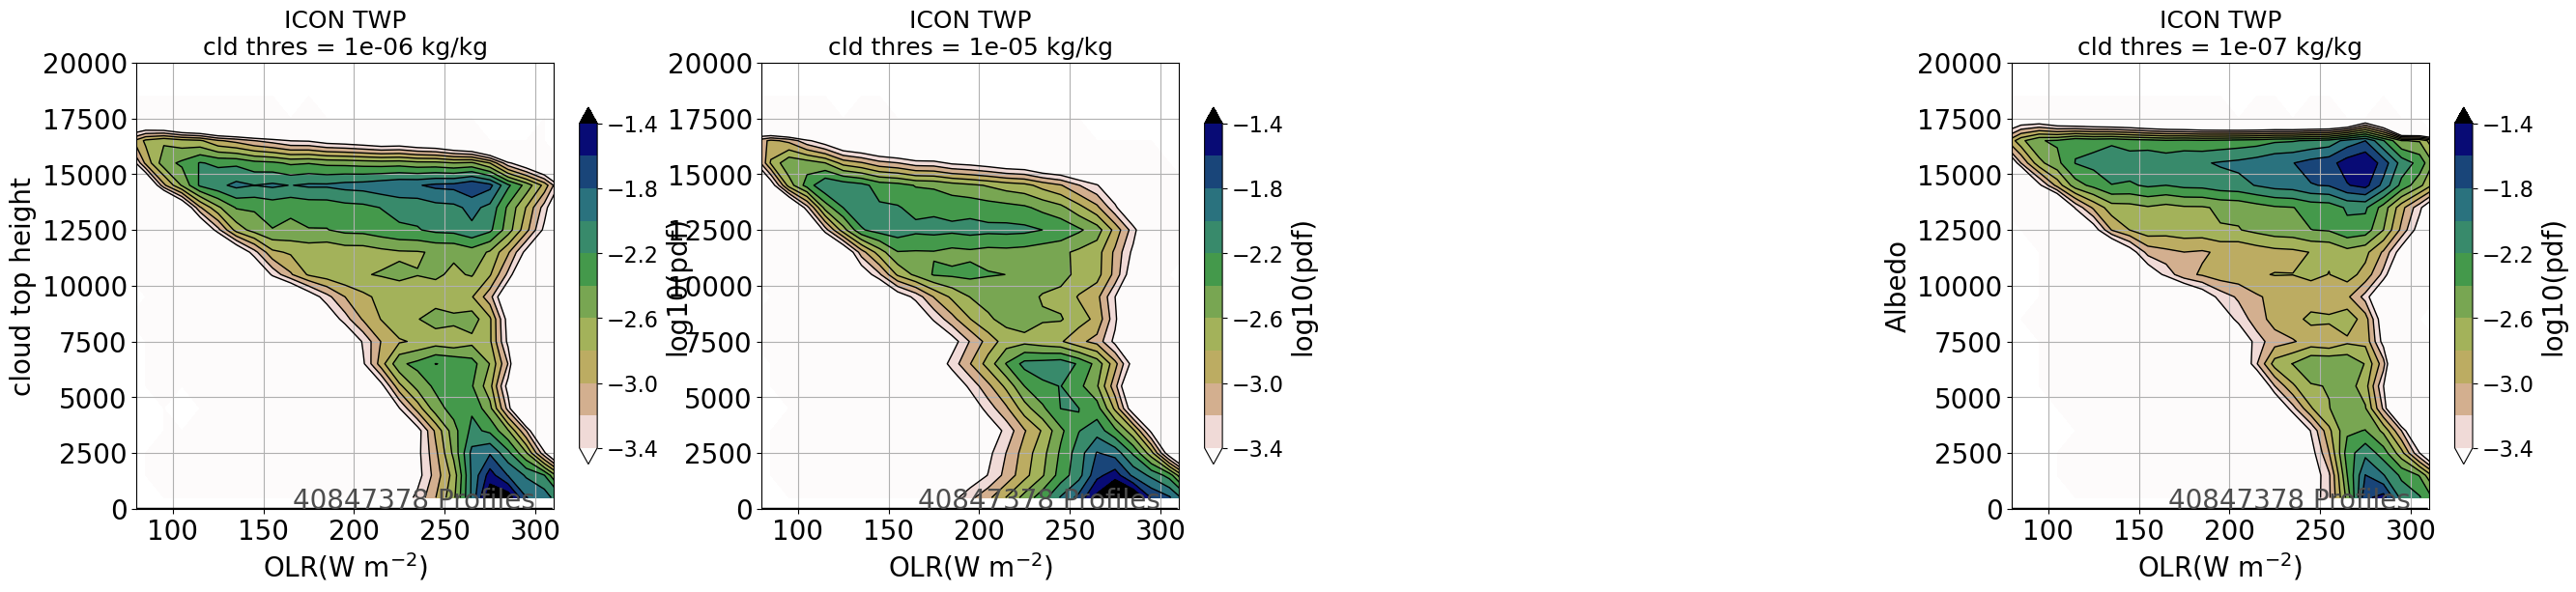

In [70]:
region="TWP"

# fig, ax = plt.subplots(1,3, figsize=(24,6))
fig, ax = plt.subplots(1,4, figsize=(24/3*4,6))
util.dennisplot("density",olr.values.flatten(), cldtop_low.values.flatten(), 
                ax=ax[0], model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[0].set_ylim([0,20000])
ax[0].set_title("{} TWP\ncld thres = {} kg/kg".format(model, 1e-6), fontsize=18)
util.dennisplot("density",olr.values.flatten(), cldtop_med.values.flatten(), 
                ax=ax[1], model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[1].set_ylim([0,20000])
ax[1].set_title("{} TWP\ncld thres = {} kg/kg".format(model, 1e-5), fontsize=18)
# util.dennisplot("density",olr.values.flatten(), cldtop_hgh.values.flatten(), 
#                 ax=ax[2], model=model, region=region,
#                 cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
#                 ybins=np.arange(0,20000,1000), colorbar_on=True)
# ax[2].set_ylim([0,20000])
# ax[2].set_title("{} TWP\ncld thres = {} kg/kg".format(model, 1e-4), fontsize=18)
ax[2].axis('off')

util.dennisplot("density",olr.values.flatten(), cldtop_xlw.values.flatten(), 
                ax=ax[3], model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[3].set_ylim([0,20000])
ax[3].set_title("{} TWP\ncld thres = {} kg/kg".format(model, 1e-7), fontsize=18)


ax[0].set_ylabel("cloud top height")
ax[1].set_ylabel("")
ax[2].set_ylabel("")

plt.savefig("../plots/TWP/cldtop_v_olr_{}.png".format(model),dpi=120)
plt.show()

In [13]:
for i in [cldtop_low, cldtop_med, cldtop_hgh]:
    print((i.where(i==0).count()/i.count()).values)


[########################################] | 100% Completed |  0.7s
0.17746782865855631
[########################################] | 100% Completed |  0.8s
0.3018176683413582
[########################################] | 100% Completed |  0.7s
0.6133990503810179


In [26]:
cldtop_high.shape

(239, 284, 284)